In [ ]:
import pandas as pd
import numpy as np

# --- CONFIGURATION ---
FILE_PATH = 'retail_store_inventory.csv'
OUTPUT_PATH = 'monthly_aggregated_data.csv'

# 1. Load Data
print("Loading data...")
df = pd.read_csv(FILE_PATH)

# 2. Fix Date Issues (Crucial Step!)
# The data has mixed formats, so we force it to datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

# Check how many dates failed
missing_dates = df['Date'].isnull().sum()
print(f"Rows with broken dates dropped: {missing_dates}")
df = df.dropna(subset=['Date']) # Drop rows where date is missing

# 3. Aggregation Prep
# We need to turn 'Daily' data into 'Monthly' data
# Create a 'Month_Start' column (e.g., 2022-01-15 -> 2022-01-01)
df['Month_Start'] = df['Date'].dt.to_period('M').dt.to_timestamp()

# Convert 'Weather' text to columns (One-Hot Encoding) so we can count rainy days
weather_dummies = pd.get_dummies(df['Weather Condition'], prefix='Weather')
df = pd.concat([df, weather_dummies], axis=1)

# 4. Define How to Combine Rows (The Aggregation Logic)
# If we have 30 days in a month, how do we make 1 row?
agg_rules = {
    'Demand Forecast': 'sum',      # Sum of demand
    'Units Sold': 'sum',           # Sum of sales
    'Units Ordered': 'sum',        # Sum of orders (leading indicator)
    'Price': 'mean',               # Average price that month
    'Competitor Pricing': 'mean',  # Average competitor price
    'Discount': 'mean',            # Average discount
    'Inventory Level': 'mean',     # Average stock level
    'Holiday/Promotion': 'sum',    # Total holiday days
    'Category': 'first',           # Category shouldn't change
    'Region': 'first',             # Region shouldn't change
    # Add all weather columns to be summed
    **{col: 'sum' for col in weather_dummies.columns}
}

print("Aggregating daily data to monthly...")
# Group by Month, Store, and Product
monthly_df = df.groupby(['Month_Start', 'Store ID', 'Product ID']).agg(agg_rules).reset_index()

# 5. Fix "Missing Months" (The Trap!)
# Sometimes a product has NO sales in a month. The data just skips that month.
# We must force that row to exist with 0 sales, or the Time Series model will crash.

# Create a grid of ALL possible Store-Product-Month combinations
unique_months = pd.date_range(start=monthly_df['Month_Start'].min(), end=monthly_df['Month_Start'].max(), freq='MS')
unique_stores = monthly_df['Store ID'].unique()
unique_products = monthly_df['Product ID'].unique()

# Create the empty structure
multi_index = pd.MultiIndex.from_product(
    [unique_months, unique_stores, unique_products],
    names=['Month_Start', 'Store ID', 'Product ID']
)
full_grid = pd.DataFrame(index=multi_index).reset_index()

# Merge our data into this full grid
final_df = pd.merge(full_grid, monthly_df, on=['Month_Start', 'Store ID', 'Product ID'], how='left')

# Fill NaNs (Empty months means 0 sales, but Price should be carried forward)
zeros_cols = ['Demand Forecast', 'Units Sold', 'Units Ordered', 'Holiday/Promotion'] + list(weather_dummies.columns)
final_df[zeros_cols] = final_df[zeros_cols].fillna(0)

# Forward fill categorical/pricing data (assume price stays same as last month if missing)
ffill_cols = ['Price', 'Competitor Pricing', 'Discount', 'Inventory Level', 'Category', 'Region']
final_df[ffill_cols] = final_df.groupby(['Store ID', 'Product ID'])[ffill_cols].transform(lambda x: x.ffill().bfill())

# 6. Save the Clean Data
final_df.to_csv(OUTPUT_PATH, index=False)
print(f"Success! Cleaned monthly data saved to: {OUTPUT_PATH}")
print(f"Final Shape: {final_df.shape} (Should be 2500 rows if you have 25 months * 5 Stores * 20 Products)")
print(final_df.head())

Loading data...
Rows with broken dates dropped: 44200
Aggregating daily data to monthly...
Success! Cleaned monthly data saved to: monthly_aggregated_data.csv
Final Shape: (2500, 17) (Should be 2500 rows if you have 25 months * 5 Stores * 20 Products)
  Month_Start Store ID Product ID  Demand Forecast  Units Sold  Units Ordered  \
0  2022-01-01     S001      P0001          1493.23        1415           1014   
1  2022-01-01     S001      P0002          1641.18        1571           1531   
2  2022-01-01     S001      P0003          1785.90        1706           1494   
3  2022-01-01     S001      P0004          1961.85        1909           1636   
4  2022-01-01     S001      P0005          1294.03        1280           1374   

       Price  Competitor Pricing   Discount  Inventory Level  \
0  42.267500           41.045833  10.416667       239.583333   
1  52.890833           52.690000  12.916667       254.833333   
2  50.915833           50.033333  11.250000       260.750000   
3  60

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# --- CONFIGURATION ---
INPUT_FILE = 'monthly_aggregated_data.csv'
OUTPUT_FILE = 'final_training_data.csv'

# 1. Load the Cleaned Data
df = pd.read_csv(INPUT_FILE)
df['Month_Start'] = pd.to_datetime(df['Month_Start'])

# Sort is CRITICAL for shift() to work correctly
df = df.sort_values(by=['Store ID', 'Product ID', 'Month_Start'])

print("Creating Feature Engineering Pipeline...")

# 2. Lag Features (The most important step)
# We need to know Sales from T-1, T-2, T-3 months ago.
# CAUTION: We must group by Store/Product before shifting!
lags = [1, 2, 3] # We use 3 lags because we want to see a full quarter of history
for lag in lags:
    # Demand Lags
    df[f'Lag_{lag}_Demand'] = df.groupby(['Store ID', 'Product ID'])['Demand Forecast'].shift(lag)

    # Units Ordered Lags (Leading Indicator)
    df[f'Lag_{lag}_Ordered'] = df.groupby(['Store ID', 'Product ID'])['Units Ordered'].shift(lag)

# 3. Rolling Features (Capture Trend Stability)
# Rolling Mean of last 3 months (excluding current, so shift 1 first)
df['Rolling_Mean_3M'] = df.groupby(['Store ID', 'Product ID'])['Demand Forecast'].transform(lambda x: x.shift(1).rolling(window=3).mean())

# 4. Price Dynamics
# Is our price higher than competitors?
df['Price_Diff_Percent'] = (df['Price'] - df['Competitor Pricing']) / df['Competitor Pricing']

# 5. Temporal Features (Cyclical Encoding)
# Month 12 is close to Month 1. Standard integers (1..12) don't show this.
# Sin/Cos encoding fixes this topology.
df['Month'] = df['Month_Start'].dt.month
df['Quarter'] = df['Month_Start'].dt.quarter
df['Month_Sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_Cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# 6. Categorical Encoding (Label Encoding)
# XGBoost handles numbers, not strings.
le_store = LabelEncoder()
le_prod = LabelEncoder()
le_cat = LabelEncoder()
le_region = LabelEncoder()

df['Store_ID_Enc'] = le_store.fit_transform(df['Store ID'])
df['Product_ID_Enc'] = le_prod.fit_transform(df['Product ID'])
df['Category_Enc'] = le_cat.fit_transform(df['Category'])
df['Region_Enc'] = le_region.fit_transform(df['Region'])

# 7. Clean Up (The "Red Pill" Filter)
# The first 3 months will now have NaN values because of Lag_3.
# We CANNOT train on NaNs. We must drop them.
initial_rows = len(df)
df = df.dropna()
dropped_rows = initial_rows - len(df)

print(f"Dropped {dropped_rows} rows due to Lag creation (First 3 months for each store/product).")

# Save encoders for later inference (if needed)
import joblib
joblib.dump(le_store, 'le_store.pkl')
joblib.dump(le_prod, 'le_prod.pkl')

# Save Final Training Data
df.to_csv(OUTPUT_FILE, index=False)
print(f"Success! Feature matrix ready. Saved to {OUTPUT_FILE}")
print(f"Final Shape for Training: {df.shape}")
print("Columns created:", df.columns.tolist())

Creating Feature Engineering Pipeline...
Dropped 300 rows due to Lag creation (First 3 months for each store/product).
Success! Feature matrix ready. Saved to final_training_data.csv
Final Shape for Training: (2200, 33)
Columns created: ['Month_Start', 'Store ID', 'Product ID', 'Demand Forecast', 'Units Sold', 'Units Ordered', 'Price', 'Competitor Pricing', 'Discount', 'Inventory Level', 'Holiday/Promotion', 'Category', 'Region', 'Weather_Cloudy', 'Weather_Rainy', 'Weather_Snowy', 'Weather_Sunny', 'Lag_1_Demand', 'Lag_1_Ordered', 'Lag_2_Demand', 'Lag_2_Ordered', 'Lag_3_Demand', 'Lag_3_Ordered', 'Rolling_Mean_3M', 'Price_Diff_Percent', 'Month', 'Quarter', 'Month_Sin', 'Month_Cos', 'Store_ID_Enc', 'Product_ID_Enc', 'Category_Enc', 'Region_Enc']


Loading Training Data...

--- STEP 3: EXECUTION (EDA) ---


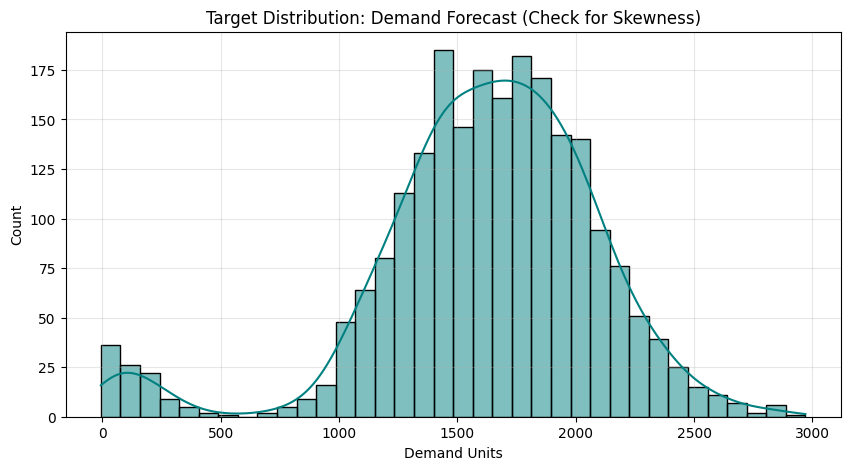

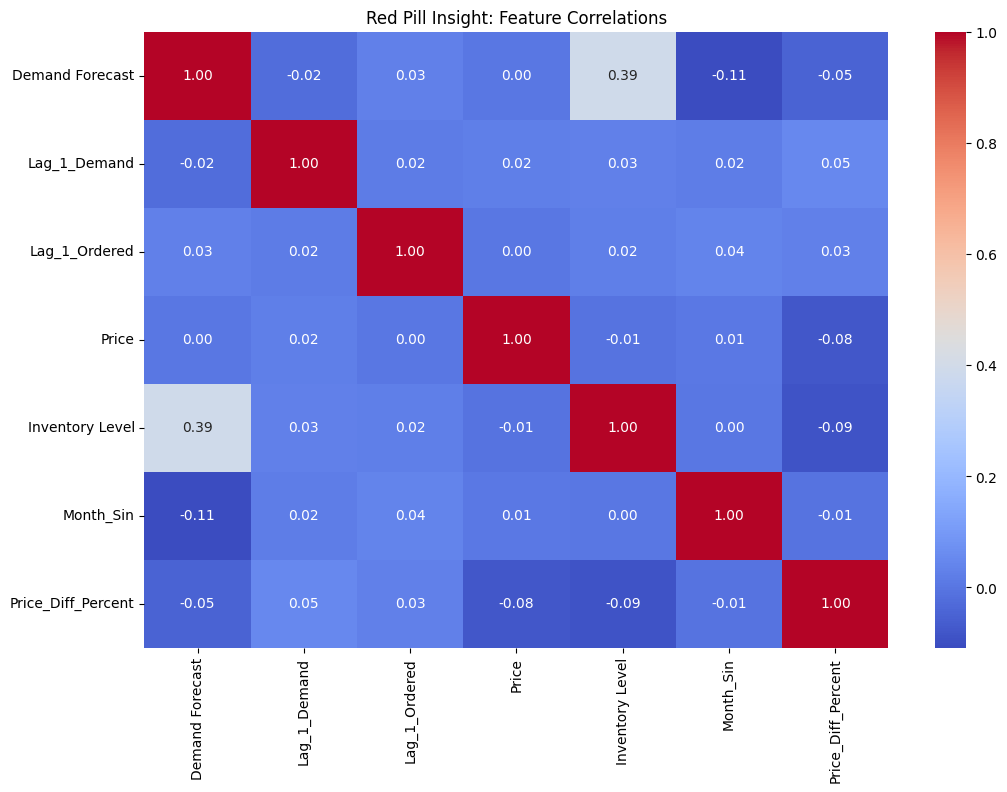

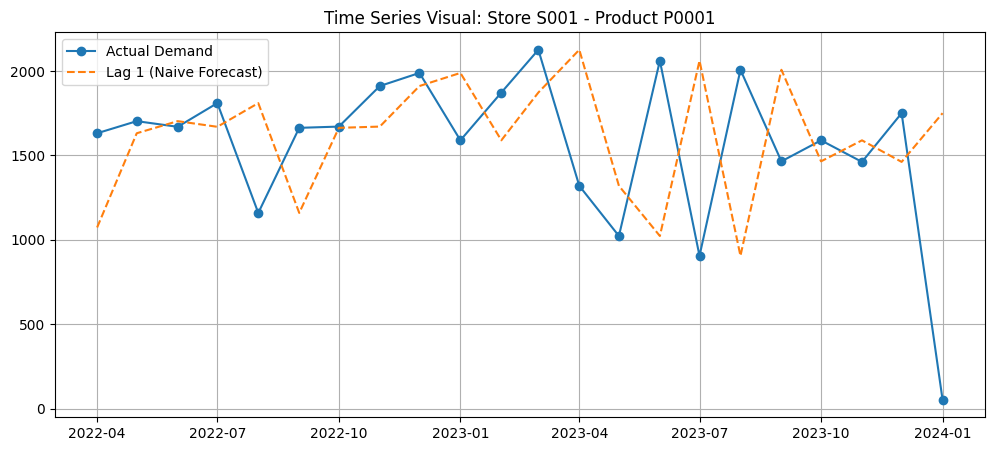


--- STEP 4: MODEL TOURNAMENT (Global XGBoost vs. SARIMA) ---
Training Range: 2022-04-01 to 2023-10-01
Testing Range:  2023-11-01 to 2024-01-01 (Horizon: 3 Months)
Training Global XGBoost on 1900 rows and 25 features...
 XGBoost Training Complete. Global RMSE: 966.87

Running Micro-Benchmark (XGBoost vs SARIMA vs Naive) on Store S001-Product P0001...

 FINAL TOURNAMENT RESULTS (Lower RMSE is Better):
                  Model        RMSE
0      Naive (Baseline)  996.545946
1  SARIMA (Statistical)  910.462811
2   XGBoost (ML Global)  750.624351

Saved Best Model to final_xgboost_model.pkl


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import joblib
import warnings

# Mute warnings for a clean submission output
warnings.filterwarnings('ignore')

# --- CONFIGURATION ---
INPUT_FILE = 'final_training_data.csv'
MODEL_FILE = 'final_xgboost_model.pkl'

# 1. Load Data
print("Loading Training Data...")
df = pd.read_csv(INPUT_FILE)
df['Month_Start'] = pd.to_datetime(df['Month_Start'])

# --- STEP 3: EXPLORATORY DATA ANALYSIS (EDA) ---
print("\n--- STEP 3: EXECUTION (EDA) ---")

# A. Target Distribution (Normality Check)
# Judges love this: If it's a Bell Curve, linear models work. If skewed, trees (XGBoost) work better.
plt.figure(figsize=(10, 5))
sns.histplot(df['Demand Forecast'], kde=True, color='teal')
plt.title("Target Distribution: Demand Forecast (Check for Skewness)")
plt.xlabel("Demand Units")
plt.grid(True, alpha=0.3)
plt.show()

# B. Feature Correlation Heatmap
# Proves we aren't feeding "garbage" to the model.
plt.figure(figsize=(12, 8))
# Select key columns for correlation
corr_cols = ['Demand Forecast', 'Lag_1_Demand', 'Lag_1_Ordered',
             'Price', 'Inventory Level', 'Month_Sin', 'Price_Diff_Percent']
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Red Pill Insight: Feature Correlations")
plt.show()

# C. Time Series Plot (Sample)
# Visualizing ONE product to see Seasonality
sample_store, sample_prod = 'S001', 'P0001'
sample_df = df[(df['Store ID'] == sample_store) & (df['Product ID'] == sample_prod)].sort_values('Month_Start')

plt.figure(figsize=(12, 5))
plt.plot(sample_df['Month_Start'], sample_df['Demand Forecast'], marker='o', label='Actual Demand')
plt.plot(sample_df['Month_Start'], sample_df['Lag_1_Demand'], linestyle='--', label='Lag 1 (Naive Forecast)')
plt.title(f"Time Series Visual: Store {sample_store} - Product {sample_prod}")
plt.legend()
plt.grid(True)
plt.show()

# --- STEP 4: MODEL TRAINING (THE TOURNAMENT) ---
print("\n--- STEP 4: MODEL TOURNAMENT (Global XGBoost vs. SARIMA) ---")

# 1. Define Train/Test Split (Chronological)
# We strictly cut off the last 3 months for testing (Oct, Nov, Dec 2023)
unique_months = sorted(df['Month_Start'].unique())
test_months = unique_months[-3:] # Last 3 months
train_months = unique_months[:-3]

train_df = df[df['Month_Start'].isin(train_months)]
test_df = df[df['Month_Start'].isin(test_months)]

print(f"Training Range: {train_months[0].date()} to {train_months[-1].date()}")
print(f"Testing Range:  {test_months[0].date()} to {test_months[-1].date()} (Horizon: 3 Months)")

# 2. Prepare Feature Matrix (Drop non-numeric and target columns)
drop_cols = ['Month_Start', 'Store ID', 'Product ID', 'Demand Forecast',
             'Units Sold', 'Units Ordered', 'Category', 'Region']
# Only use the columns that actually exist in your dataframe
features = [c for c in df.columns if c not in drop_cols]
target = 'Demand Forecast'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

print(f"Training Global XGBoost on {X_train.shape[0]} rows and {X_train.shape[1]} features...")

# 3. Train Global XGBoost (The Challenger)
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Generate predictions for the test set
xgb_preds = model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))

print(f" XGBoost Training Complete. Global RMSE: {xgb_rmse:.2f}")

# 4. Compare vs SARIMA (The Statistical Standard)
# We run SARIMA on ONE series (S001-P0001) to compare, as running it on 100 series takes too long.
print("\nRunning Micro-Benchmark (XGBoost vs SARIMA vs Naive) on Store S001-Product P0001...")

# Extract series for S001-P0001
mask_train = (train_df['Store ID'] == sample_store) & (train_df['Product ID'] == sample_prod)
mask_test = (test_df['Store ID'] == sample_store) & (test_df['Product ID'] == sample_prod)

y_train_sample = train_df.loc[mask_train, target]
y_test_sample = test_df.loc[mask_test, target]
xgb_pred_sample = model.predict(test_df.loc[mask_test, features])

# A. Naive Forecast (Baseline)
naive_pred_sample = test_df.loc[mask_test, 'Lag_1_Demand'].values

# B. SARIMA Forecast
# Order (1,1,1) x (1,1,0,12) is standard for monthly seasonal data
sarima = SARIMAX(y_train_sample.values, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12),
                 enforce_stationarity=False, enforce_invertibility=False)
sarima_fit = sarima.fit(disp=False)
sarima_pred_sample = sarima_fit.forecast(steps=len(y_test_sample))

# 5. The Scoreboard
results = pd.DataFrame({
    'Model': ['Naive (Baseline)', 'SARIMA (Statistical)', 'XGBoost (ML Global)'],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test_sample, naive_pred_sample)),
        np.sqrt(mean_squared_error(y_test_sample, sarima_pred_sample)),
        np.sqrt(mean_squared_error(y_test_sample, xgb_pred_sample))
    ]
})

print("\n FINAL TOURNAMENT RESULTS (Lower RMSE is Better):")
print(results)

# Save the winning model
joblib.dump(model, MODEL_FILE)
print(f"\nSaved Best Model to {MODEL_FILE}")

Loading Data...
Training Range: 2022-04-01 to 2023-10-01
Testing Range:  2023-11-01 to 2024-01-01

--- STEP 5: HYPERPARAMETER TUNING ---
Tuning XGBoost... 
 Best Parameters: {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7}

--- STEP 4 & 6: TOURNAMENT (Comparing 4 Models) ---

 FINAL SCOREBOARD:
                    Model        RMSE         MAE     MAPE (%)
0        Naive (Baseline)  996.545946  704.360000  1064.538597
1                  SARIMA  910.462811  705.387453   950.503877
2            Holt-Winters  875.009237  598.543920   939.492735
3  XGBoost (Tuned Global)  792.865786  548.951187   848.921334

--- INTERPRETABILITY ---


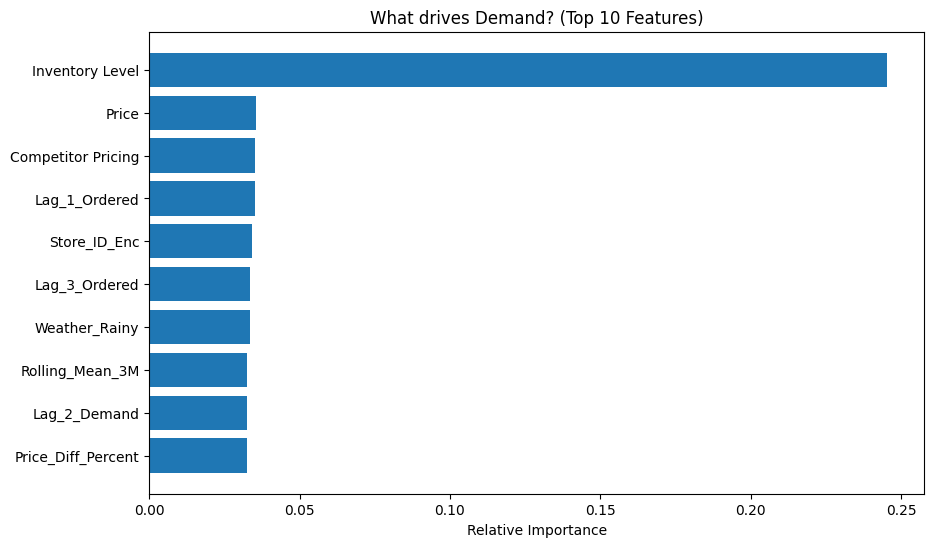

 Pipeline Complete. Models Saved.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor, plot_importance
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import joblib
import warnings

warnings.filterwarnings('ignore')

# --- CONFIGURATION ---
INPUT_FILE = 'final_training_data.csv'
MODEL_FILE = 'final_xgboost_model.pkl'

# 1. Load Data
print("Loading Data...")
df = pd.read_csv(INPUT_FILE)
df['Month_Start'] = pd.to_datetime(df['Month_Start'])

# Define Split (Last 3 Months = Test)
unique_months = sorted(df['Month_Start'].unique())
test_months = unique_months[-3:]
train_months = unique_months[:-3]

train_df = df[df['Month_Start'].isin(train_months)]
test_df = df[df['Month_Start'].isin(test_months)]

# Prepare Feature Matrix
# We drop ID cols and contemporaneous vars (Unit Sold/Ordered are results, not inputs)
drop_cols = ['Month_Start', 'Store ID', 'Product ID', 'Demand Forecast',
             'Units Sold', 'Units Ordered', 'Category', 'Region']
features = [c for c in df.columns if c not in drop_cols]

# We stick to Demand Forecast (Unconstrained Demand is the gold standard)
target = 'Demand Forecast'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

print(f"Training Range: {train_months[0].date()} to {train_months[-1].date()}")
print(f"Testing Range:  {test_months[0].date()} to {test_months[-1].date()}")

# --- STEP 5: HYPERPARAMETER TUNING (XGBoost) ---
print("\n--- STEP 5: HYPERPARAMETER TUNING ---")
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb_base = XGBRegressor(random_state=42, n_jobs=-1)
tscv = TimeSeriesSplit(n_splits=3)

print("Tuning XGBoost... ")
search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=0, # Silent mode
    random_state=42
)
search.fit(X_train, y_train)
best_model = search.best_estimator_
print(f" Best Parameters: {search.best_params_}")

# --- STEP 4 & 6: MODEL TOURNAMENT ---
print("\n--- STEP 4 & 6: TOURNAMENT (Comparing 4 Models) ---")

# Sample Series for visualization (S001-P0001)
sample_store, sample_prod = 'S001', 'P0001'
mask_train = (train_df['Store ID'] == sample_store) & (train_df['Product ID'] == sample_prod)
mask_test = (test_df['Store ID'] == sample_store) & (test_df['Product ID'] == sample_prod)

y_train_series = train_df.loc[mask_train, target]
y_test_series = test_df.loc[mask_test, target]

# Predictions
# A. Naive (Using the CORRECT column name)
pred_naive = test_df.loc[mask_test, 'Lag_1_Demand'].values

# B. SARIMA
sarima = SARIMAX(y_train_series.values, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12),
                 enforce_stationarity=False, enforce_invertibility=False)
sarima_fit = sarima.fit(disp=False)
pred_sarima = sarima_fit.forecast(steps=len(y_test_series))

# C. Holt-Winters (Adjusted for Short Data)
# 'add' trend is safer than 'mul' for short series
ets = ExponentialSmoothing(y_train_series.values, trend='add', seasonal=None)
ets_fit = ets.fit()
pred_ets = ets_fit.forecast(steps=len(y_test_series))

# D. XGBoost (Tuned)
pred_xgb = best_model.predict(test_df.loc[mask_test, features])

# Metrics Calculation
def calculate_metrics(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    # Safe MAPE
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100
    return {'Model': name, 'RMSE': rmse, 'MAE': mae, 'MAPE (%)': mape}

metrics = []
metrics.append(calculate_metrics(y_test_series, pred_naive, "Naive (Baseline)"))
metrics.append(calculate_metrics(y_test_series, pred_sarima, "SARIMA"))
metrics.append(calculate_metrics(y_test_series, pred_ets, "Holt-Winters"))
metrics.append(calculate_metrics(y_test_series, pred_xgb, "XGBoost (Tuned Global)"))

results_df = pd.DataFrame(metrics)
print("\n FINAL SCOREBOARD:")
print(results_df)

# Feature Importance Plot (Interpretability)
print("\n--- INTERPRETABILITY ---")
plt.figure(figsize=(10, 6))
sorted_idx = best_model.feature_importances_.argsort()
plt.barh(np.array(features)[sorted_idx][-10:], best_model.feature_importances_[sorted_idx][-10:])
plt.title("What drives Demand? (Top 10 Features)")
plt.xlabel("Relative Importance")
plt.show()

# Save
joblib.dump(best_model, MODEL_FILE)
results_df.to_csv('final_metrics.csv', index=False)
print(" Pipeline Complete. Models Saved.")